We have been provided with price and financial data for 100 US stocks. <br>
We need to generate 1 day ahead trading signals for each stock. We must select the ten best stocks each day to form a portfolio. <br>
The performace of the portfolio will be evaluated based on the total return index over the evaluation period. 

This is known as swing trading.
1. We are only allowed long positions. 
2. The matrix of buys will only contain 1's and 0's

In [4]:
import pandas as pd #for manipulating data
import numpy as np #for data operations
import matplotlib.pyplot as plt #for plotting how much money the portfolio makes

In [5]:
#next we want to load the data
#data0 contains security sector data
#data1 contains price, historical returns, financial ratios and the 1 day ahead price change label

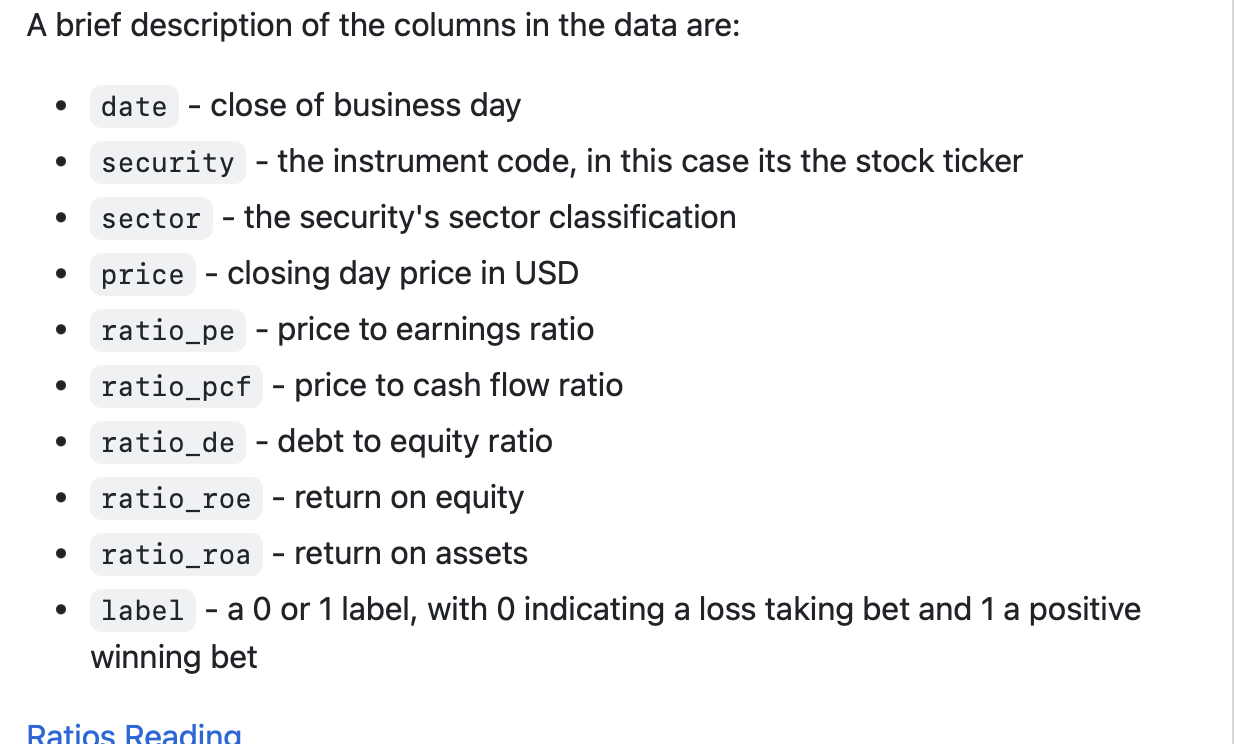

### <mark>ratio_pe</mark>
Price to earnings ratio
Measures how expensive a stock is relative to its earnings
$$
\frac {stockPrice}{earningsPerStock}
$$
A higher pe ratio can mean the comapny is over valued or expected to grow
<br><br>

### <mark>ratio_pcf</mark>
Price to cash flow ratio
$$
\frac {stockPrice}{OperatingCashFlow}
$$
Can provide a more straightforward comparision than PE ratio. This is because cash flow does not include noncash expenses. Eliminating these can help remove differences in how companies depreciate their assets.<br> Lower pcf is preferable 
<br><br>

### <mark>ratio_de</mark>
Debt to equity ratio
$$
\frac {totalDebt}{shareholdersEquity}
$$
This percentage tells you how much a company is financed with debt. Higher values can mean higher risk. However established companies normally have a higher debt equity ratio. Unlike rapidly growing companies.<br>Lower values are preferable
<br><br>

### <mark>ratio_roe</mark>
Return on equity ratio
$$
\frac {netIncome}{shareholdersEquity}
$$
Measures how efficiently a company generates profits from money invested in the company. Useful for measuring a companies effectiveness
<br><br>

### <mark>ratio_roa</mark>
Return on assets ratio
$$
\frac {netIncome}{totalAssets}
$$
Measures how efficiently a company generates profits from given base of assets. Companies with a low roa would have to borrow or raise equity to achive te same amount of profit.
Also useuful for measuring a companies effectiveness
<br><br>

### <mark>label</mark>
A 0 or 1 label.
$$
0 / 1
$$
Where 0 means the stock went down the following day and 1 means the stock went up the following day.
A loss taking bet and a positive winning taking bet

In [6]:
#Load the data
df0 = pd.read_csv('data/data0.csv')
df1 = pd.read_csv('data/data1.csv')

#show the first few rows of df1
df1.head()
#df1 contains historical features and labels

,date,security,price,return30,ratio_pe,ratio_pcf,ratio_de,ratio_roe,ratio_roa,label
0,2017-01-03,AAPL,29.04,0.056769,3.477844,-4.570000e-08,-59.647701,0.464198,0.56166,0
1,2017-01-04,AAPL,29.01,0.063416,3.474251,-4.560000e-08,-59.647701,0.464198,0.56166,1
2,2017-01-05,AAPL,29.15,0.060386,3.491018,-4.580000e-08,-59.647701,0.464198,0.56166,1
3,2017-01-06,AAPL,29.48,0.061960,3.530539,-4.640000e-08,-59.647701,0.464198,0.56166,1
4,2017-01-09,AAPL,29.75,0.044226,3.562874,-4.680000e-08,-59.647701,0.464198,0.56166,1


In [7]:
#next we want to clean the data
#we will drop all the rows where the label is missing
df1 = df1.dropna(subset=['label'])

#confirm label has no missing values
df1['label'].isna().sum()

#we are going to use the label column to train the model
#we need all label values present. No Nan

0

In [8]:
#feature selection
#selecting which columns we will use as inputs (X) to predict whether a stock will go up
features = [
    'return_1d', 'return_5d', 'return_21d', 'return_63d', 'return_252d',
    'ratio_pe', 'ratio_pb', 'ratio_ps', 'ratio_pc', 'ratio_div',
    'ratio_de', 'ratio_roa', 'ratio_roe', 'ratio_roi']

In [9]:
#split the data into a training period and a testing period
#we are interested in the returns for the period 2024-01-01 / 2024-06-30
train = df1[df1['date'] < '2024-01-01']
train = train.copy()
test = df1[(df1['date'] >= '2024-01-01') & (df1['date'] <= '2024-06-30')]
test = test.copy()

test_logistic = test.copy()
test_lstsq = test.copy()

#train a simple least squares regression model
available_features = [f for f in features if f in df1.columns]

train['intercept'] = 1.0
X_train = train[available_features + ['intercept']]
y_train = train['label']

from numpy.linalg import lstsq
model1 = lstsq(X_train, y_train, rcond=None)[0]
model1

array([3.03036811e-06, 2.10621774e-07, 3.43729836e-03, 3.08002358e-05,
       5.24591318e-01])

We now have a weight table trained on all the data using the least squares method
These weights are the best fit to get as close as possibleeee to the target value 1 or 0 for all stocks on all days. So if we want to predict if a stock will go up now we plug in the features for that day and observe if the output is closer to 1 or 0

In [10]:
#train a logistic regression
#uses the log odds of the output to find the best weights
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

### Normalise the features for the logistics regression model

In [11]:
#if the features are on widly different scales the LRM can perform badly
#we will use standard scalar to standardise

#extract raw features and labels
X_train2 = train[available_features].copy()
y_train2 = train['label']
X_test2 = test[available_features].copy()

#scale. Fit on train, transform on both
scalar = StandardScaler()
X_train2_scaled = scalar.fit_transform(X_train2) #calc the mean and deviation on the train data
X_test_scaled = scalar.transform(X_test2) #apply the transform to both
#now both sets have a mean of 0 and Std of 1 making the training model more fair 

### Train the logistics model

In [12]:
log_model = LogisticRegression(random_state=42, max_iter=1000)
log_model.fit(X_train2_scaled, y_train2)
#now the optimal weights are calculated to give 1 or 0 for all stocks on every day again

LogisticRegression(max_iter=1000, random_state=42)

### Predict prob on test period

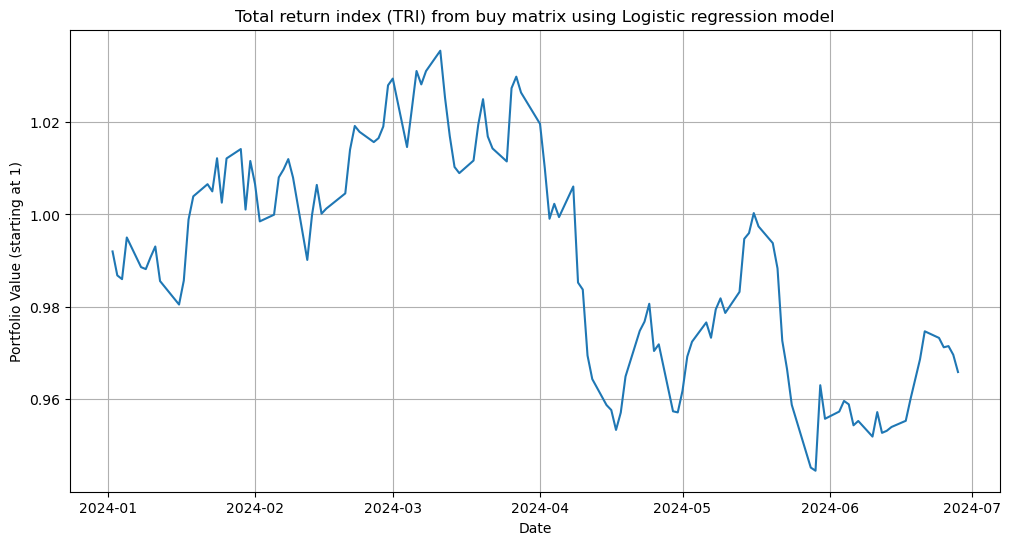

In [13]:
test_logistic['pred'] = log_model.predict_proba(X_test_scaled)[:, 1]
test_logistic['rank'] = test_logistic.groupby('date')['pred'].rank(method='first', ascending=False)
test_logistic['buy'] = (test_logistic['rank'] <= 10).astype(int)
buy_matrix_log = test_logistic.pivot(index='date', columns='security', values='buy').fillna(0).astype(int)

#read in the returns csv
returns = pd.read_csv('data/returns.csv', parse_dates=['date'])

#melt the buy matrix back to long format
buy_signals_log = buy_matrix_log.reset_index().melt(id_vars='date', var_name='security', value_name='buy')

#keep the rows where buy = 1
buy_signals_log = buy_signals_log[buy_signals_log['buy'] == 1]

#convert date column to datetime for correct merge
buy_signals_log['date'] = pd.to_datetime(buy_signals_log['date'])

#merge with actual returns
buy_returns_log = buy_signals_log.merge(returns, on=['date', 'security'])

#daily average returns
daily_return_log = buy_returns_log.groupby('date')['return1'].mean()

tri_log = (1 + daily_return_log).cumprod()
plt.figure(figsize=(12, 6))
plt.plot(tri_log)
plt.title("Total return index (TRI) from buy matrix using Logistic regression model")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (starting at 1)")
plt.grid()
plt.show()

In [14]:
#create a new column that dots all features for all stocks with the weights on test set
test_lstsq['intercept'] = 1.0
X_test_ls = test_lstsq[available_features + ['intercept']]
test_lstsq['pred'] = np.dot(X_test_ls, model1)
#higher score will mean the model thinks the stock will go up
#we will rank stocks daily by score and pick the top 10
#group by each date
#assign a rank for each stock grouped by date. In descending order
#method=first ensures if there are ties the rank  appears in the order the
#stock appeared in the table
test_lstsq['rank'] = test_lstsq.groupby('date')['pred'].rank(method='first', ascending=False)
#next we select top 10 stocks for each date creating a boolean column
test_lstsq['buy'] = (test_lstsq['rank'] <= 10).astype(int)

#then turn into a buy matrix where columns are the securities for each date
#and the values are what each security had stored in buy column
buy_matrix_ls = test_lstsq.pivot(index='date', columns='security', values='buy').fillna(0).astype(int)
#buy_matrix_ls.head(10)

### Compute the returns from the buy matrix

In [15]:
#melt the buy matrix back to long format
buy_signals_ls = buy_matrix_ls.reset_index().melt(id_vars='date', var_name='security', value_name='buy')

#keep the rows where buy = 1
buy_signals_ls = buy_signals_ls[buy_signals_ls['buy'] == 1]

#convert date column to datetime for correct merge
buy_signals_ls['date'] = pd.to_datetime(buy_signals_ls['date'])

#merge with actual returns
buy_returns_ls = buy_signals_ls.merge(returns, on=['date', 'security'])

#daily average returns
daily_return_ls = buy_returns_ls.groupby('date')['return1'].mean()



### Compute the total return index

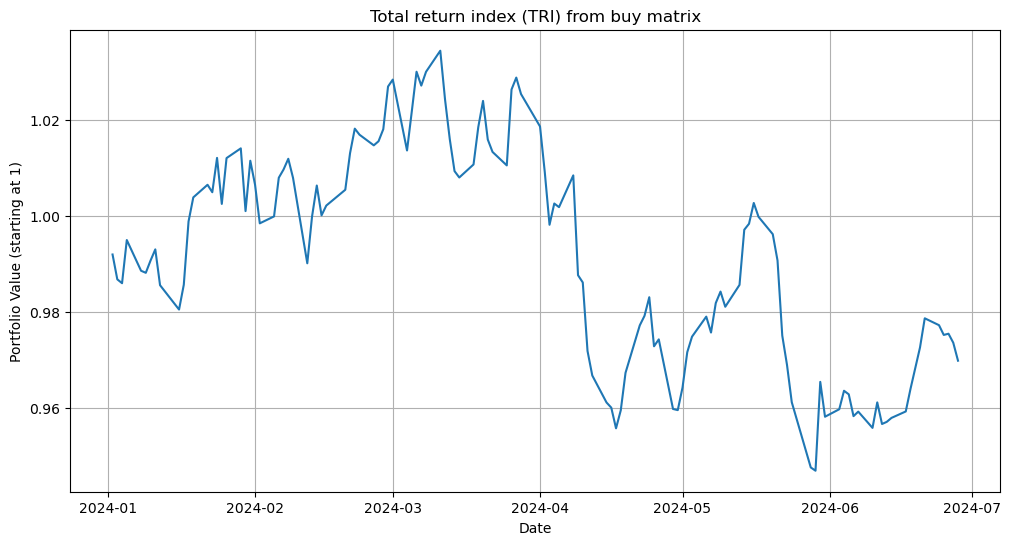

In [16]:
tri_ls = (1 + daily_return_ls).cumprod()
plt.figure(figsize=(12, 6))
plt.plot(tri_ls)
plt.title("Total return index (TRI) from buy matrix")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (starting at 1)")
plt.grid()
plt.show()

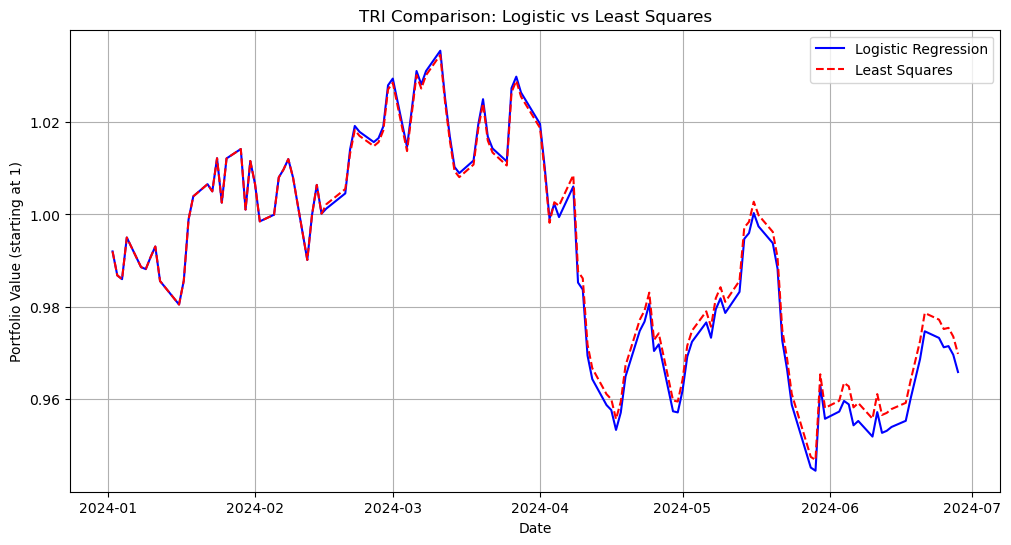

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(tri_log, label='Logistic Regression', linestyle='-', color='blue')
plt.plot(tri_ls, label='Least Squares', linestyle='--', color='red')
plt.title("TRI Comparison: Logistic vs Least Squares")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (starting at 1)")
plt.grid()
plt.legend()
plt.show()


# Last Year's Solution Implementation

This section implements the complete solution from the previous year's challenge, which used a Random Forest classifier with walk-forward validation to generate buy signals for stock selection.

In [18]:
# Import required libraries for the solution
import numpy as np
import pandas as pd
import datetime

import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

print('---> Python Script Start', t0 := datetime.datetime.now())

---> Python Script Start 2025-09-20 07:00:48.666311


In [19]:
print('---> the parameters')

# training and test dates
start_train = datetime.date(2017, 1, 1)
end_train = datetime.date(2023, 11, 30) # gap for embargo (no overlap between train and test)
start_test = datetime.date(2024, 1, 1) # test set is this datasets 2024 data
end_test = datetime.date(2024, 6, 30)

n_buys = 10
verbose = False

---> the parameters


In [20]:
print('---> initial data set up')

# sector data
df_sectors = pd.read_csv('data/data0.csv')

# price and fin data
df_data = pd.read_csv('data/data1.csv')
df_data['date'] = pd.to_datetime(df_data['date']).apply(lambda d: d.date())

df_x = df_data[['date', 'security', 'price', 'return30', 'ratio_pe', 'ratio_pcf', 'ratio_de', 'ratio_roe', 'ratio_roa']].copy()
df_y = df_data[['date', 'security', 'label']].copy()

list_vars1 = ['price', 'return30', 'ratio_pe', 'ratio_pcf', 'ratio_de', 'ratio_roe', 'ratio_roa']

# we will perform walk forward validation for testing the buys - https://www.linkedin.com/pulse/walk-forward-validation-yeshwanth-n
df_signals = pd.DataFrame(data={'date':df_x.loc[(df_x['date']>=start_test) & (df_x['date']<=end_test), 'date'].values})
df_signals.drop_duplicates(inplace=True)
df_signals.reset_index(drop=True, inplace=True)
df_signals.sort_values(by='date', inplace=True) # this code just gets the dates that we need to generate buy signals for

---> initial data set up


In [21]:
# Walk-forward validation loop for generating buy signals
# Initialize the classifier outside the loop
clf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=10, min_samples_split=1000, min_samples_leaf=1000, min_weight_fraction_leaf=0.0, max_features='sqrt', random_state=0)

for i in range(len(df_signals)):

    if verbose: print('---> doing', df_signals.loc[i, 'date'])

    # this iterations training set
    df_trainx = df_x[df_x['date']<df_signals.loc[i, 'date']].copy()
    df_trainx.drop(labels=df_trainx[df_trainx['date']==df_trainx['date'].max()].index, inplace=True) # no overlap with test set

    df_trainy = df_y[df_y['date']<df_signals.loc[i, 'date']].copy()
    df_trainy.drop(labels=df_trainy[df_trainy['date']==df_trainy['date'].max()].index, inplace=True) # no overlap with test set

    # this iterations test set
    df_testx = df_x[df_x['date']>=df_signals.loc[i, 'date']].copy()
    df_testy = df_y[df_y['date']>=df_signals.loc[i, 'date']].copy()

    # scale, and store scaling objects for test set
    dict_scaler = {}
    for col in list_vars1:

        dict_scaler[col] = MinMaxScaler(feature_range=(-1,1))
        df_trainx[col] = dict_scaler[col].fit_transform(np.array(df_trainx[col]).reshape((len(df_trainx[col]),1)))[:, 0]
        df_testx[col] = dict_scaler[col].transform(np.array(df_testx[col]).reshape((len(df_testx[col]),1)))[:, 0]

    # fit a classifier (only on first iteration to avoid overfitting)
    if i == 0:
        clf.fit(np.array(df_trainx[list_vars1]), np.array(df_trainy['label']))

    # predict and calc accuracy - 0.5 is the implicit cuttoff here
    df_testy['signal'] = clf.predict_proba(np.array(df_testx[list_vars1]))[:, 1] # use probs to get strength of classification
    df_testy['pred'] = clf.predict(np.array(df_testx[list_vars1]))
    df_testy['count'] = 1

    df_current = df_testy[df_testy['date']==df_signals.loc[i, 'date']]

    acc_total = (df_testy['label'] == df_testy['pred']).sum()/len(df_testy)
    acc_current = (df_current['label'] == df_current['pred']).sum()/len(df_current)
    
    print('---> accuracy test set', round(acc_total, 2), ', accuracy current date', round(acc_current, 2))

    # add accuracy and signal to dataframe
    df_signals.loc[i, 'acc_total'] = acc_total
    df_signals.loc[i, 'acc_current'] = acc_current

    # Store signals for each security in the current date
    for security, signal_value in zip(df_current['security'].values, df_current['signal'].values):
        df_signals.loc[i, security] = signal_value

---> accuracy test set 0.52 , accuracy current date 0.27


/tmp/ipykernel_38902/4254398595.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_signals.loc[i, security] = signal_value
/tmp/ipykernel_38902/4254398595.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_signals.loc[i, security] = signal_value
/tmp/ipykernel_38902/4254398595.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

---> accuracy test set 0.52 , accuracy current date 0.49
---> accuracy test set 0.52 , accuracy current date 0.54
---> accuracy test set 0.52 , accuracy current date 0.54
---> accuracy test set 0.52 , accuracy current date 0.83
---> accuracy test set 0.52 , accuracy current date 0.83
---> accuracy test set 0.52 , accuracy current date 0.42
---> accuracy test set 0.52 , accuracy current date 0.42
---> accuracy test set 0.52 , accuracy current date 0.62
---> accuracy test set 0.52 , accuracy current date 0.62
---> accuracy test set 0.52 , accuracy current date 0.49
---> accuracy test set 0.52 , accuracy current date 0.49
---> accuracy test set 0.52 , accuracy current date 0.56
---> accuracy test set 0.52 , accuracy current date 0.56
---> accuracy test set 0.52 , accuracy current date 0.37
---> accuracy test set 0.52 , accuracy current date 0.37
---> accuracy test set 0.52 , accuracy current date 0.29
---> accuracy test set 0.52 , accuracy current date 0.29
---> accuracy test set 0.52 , a

## 🚫 Data Leakage Prevention: The "Embargo Day" Explained

**The Problem:** In financial prediction, we want to predict whether a stock will go **UP** or **DOWN** tomorrow based on today's features. However, there's a subtle but critical data leakage issue:

### 📅 **Timeline Example:**
Let's say we're predicting for **January 3rd, 2024**:

- **December 31st, 2023**: Market closes, we have all features (price, ratios, etc.)
- **January 1st, 2024**: Market closed (New Year's Day)  
- **January 2nd, 2024**: Market closed (observed New Year's Day)
- **January 3rd, 2024**: **TARGET DAY** - Market opens, we want to predict if stocks go up/down

### ⚠️ **The Data Leakage Risk:**
If we include **January 2nd data** in training:
- January 2nd features might contain information that's "too close" to January 3rd
- Pre-market movements, news, or other factors from January 2nd could give unfair hints about January 3rd performance
- This creates **look-ahead bias** - using information that wouldn't be available in real trading

### 🛡️ **The Solution - Embargo Period:**
```python
# Remove the day immediately before current prediction date
df_trainx.drop(labels=df_trainx[df_trainx['date']==df_trainx['date'].max()].index, inplace=True)
```

**What this does:**
- If predicting for **January 3rd**, remove **January 2nd** from training
- If predicting for **January 4th**, remove **January 3rd** from training  
- If predicting for **January 5th**, remove **January 4th** from training

### 🔍 **Step-by-Step Breakdown:**

1. **Get all data before current date:**
   ```python
   df_trainx = df_x[df_x['date'] < current_date].copy()  # All data before Jan 3rd
   ```
   This gives us: [Dec 31st, Jan 1st, Jan 2nd] ← **Jan 2nd is problematic!**

2. **Remove the most recent day (embargo):**
   ```python
   df_trainx.drop(labels=df_trainx[df_trainx['date']==df_trainx['date'].max()].index, inplace=True)
   ```
   This removes: **Jan 2nd** (the max date)
   
   **Final training data:** [Dec 31st, Jan 1st] ← **Safe!**

### 💡 **Why This Matters:**
- **Real Trading Simulation**: Mimics actual constraints where you can't use "yesterday's close" to predict "today's movement"
- **Prevents Overfitting**: Removes artificially inflated performance from near-term correlations
- **Regulatory Compliance**: Many financial regulations require this type of embargo period
- **Conservative Approach**: Better to be safe and have slightly lower performance than to have unrealistic backtesting results

### 📊 **Example Timeline:**
```
Training Data Available: [..., Dec 29, Dec 30, Dec 31, Jan 1, Jan 2]
Predicting for: Jan 3

Step 1 - Get data before Jan 3: [Dec 29, Dec 30, Dec 31, Jan 1, Jan 2]
Step 2 - Remove embargo day (Jan 2): [Dec 29, Dec 30, Dec 31, Jan 1]
Final training set: [Dec 29, Dec 30, Dec 31, Jan 1] ✅
```

This ensures **clean, unbiased predictions** that would work in real-world trading!

In [1]:
# Let's demonstrate the embargo day removal with a concrete example
import pandas as pd
import datetime

# Create a sample timeline to show what's happening
print("=== EMBARGO DAY DEMONSTRATION ===\n")

# Sample dates around January 3rd, 2024 prediction
sample_dates = [
    datetime.date(2023, 12, 29),
    datetime.date(2023, 12, 30),  
    datetime.date(2023, 12, 31),
    datetime.date(2024, 1, 1),
    datetime.date(2024, 1, 2),
    datetime.date(2024, 1, 3),  # ← This is our PREDICTION TARGET
    datetime.date(2024, 1, 4)
]

# Let's say we're predicting for January 3rd, 2024
current_prediction_date = datetime.date(2024, 1, 3)

print(f"🎯 PREDICTING FOR: {current_prediction_date}")
print(f"📊 Available historical dates: {sample_dates[:6]}")  # Exclude future dates
print()

# Step 1: Get all data before current date (this is what the code does initially)
available_before_current = [d for d in sample_dates if d < current_prediction_date]
print(f"📅 STEP 1 - All data before {current_prediction_date}:")
print(f"   {available_before_current}")
print(f"   → Most recent training date: {max(available_before_current)}")
print()

# Step 2: Remove the embargo day (most recent day)
embargo_day = max(available_before_current)
final_training_dates = [d for d in available_before_current if d != embargo_day]

print(f"🚫 STEP 2 - Remove embargo day ({embargo_day}):")
print(f"   Final training dates: {final_training_dates}")
print(f"   → Embargo day removed: {embargo_day}")
print(f"   → Gap between training and prediction: {(current_prediction_date - max(final_training_dates)).days} day(s)")
print()

print("✅ RESULT: Clean training data with no data leakage risk!")
print(f"   - We use features up to: {max(final_training_dates)}")  
print(f"   - To predict performance on: {current_prediction_date}")
print(f"   - This prevents using '{embargo_day}' data that might contain hints about '{current_prediction_date}' performance")

=== EMBARGO DAY DEMONSTRATION ===

🎯 PREDICTING FOR: 2024-01-03
📊 Available historical dates: [datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 1, 1), datetime.date(2024, 1, 2), datetime.date(2024, 1, 3)]

📅 STEP 1 - All data before 2024-01-03:
   [datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 1, 1), datetime.date(2024, 1, 2)]
   → Most recent training date: 2024-01-02

🚫 STEP 2 - Remove embargo day (2024-01-02):
   Final training dates: [datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 1, 1)]
   → Embargo day removed: 2024-01-02
   → Gap between training and prediction: 2 day(s)

✅ RESULT: Clean training data with no data leakage risk!
   - We use features up to: 2024-01-01
   - To predict performance on: 2024-01-03
   - This prevents using '2024-01-02' data that might contain hints about '2024-01-03' performan

In [2]:
# Let's see exactly what the actual code does step by step
print("\n" + "="*60)
print("🔍 RECREATING THE ACTUAL CODE LOGIC")
print("="*60)

# Simulate the actual dataframe operations
df_sample = pd.DataFrame({
    'date': [datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), 
             datetime.date(2023, 12, 31), datetime.date(2024, 1, 1), 
             datetime.date(2024, 1, 2), datetime.date(2024, 1, 3)],
    'security': ['AAPL']*6,
    'price': [150, 151, 152, 153, 154, 155],
    'label': [1, 0, 1, 0, 1, 0]
})

current_date = datetime.date(2024, 1, 3)
print(f"📊 Original dataframe:")
print(df_sample)
print()

# Step 1: Get training data (all data before current date)
print(f"🎯 Current prediction date: {current_date}")
df_trainx = df_sample[df_sample['date'] < current_date].copy()
print(f"📅 After filtering date < {current_date}:")
print(df_trainx)
print(f"   → Latest date in training: {df_trainx['date'].max()}")
print()

# Step 2: Remove the embargo day (the exact code from the notebook)
print("🚫 Applying embargo removal:")
print("   Code: df_trainx.drop(labels=df_trainx[df_trainx['date']==df_trainx['date'].max()].index, inplace=True)")

# Find the max date
max_date = df_trainx['date'].max()
print(f"   → Max date found: {max_date}")

# Find rows with max date
rows_to_remove = df_trainx[df_trainx['date'] == max_date].index
print(f"   → Rows to remove (indices): {list(rows_to_remove)}")

# Remove those rows
df_trainx.drop(labels=rows_to_remove, inplace=True)
print(f"📅 Final training dataframe:")
print(df_trainx)
print(f"   → New latest training date: {df_trainx['date'].max()}")
print(f"   → Embargo day ({max_date}) successfully removed!")

print(f"\n✅ SUMMARY:")
print(f"   - Predicting for: {current_date}")
print(f"   - Embargo day removed: {max_date}")  
print(f"   - Final training data ends: {df_trainx['date'].max()}")
print(f"   - Days gap: {(current_date - df_trainx['date'].max()).days}")


🔍 RECREATING THE ACTUAL CODE LOGIC
📊 Original dataframe:
         date security  price  label
0  2023-12-29     AAPL    150      1
1  2023-12-30     AAPL    151      0
2  2023-12-31     AAPL    152      1
3  2024-01-01     AAPL    153      0
4  2024-01-02     AAPL    154      1
5  2024-01-03     AAPL    155      0

🎯 Current prediction date: 2024-01-03
📅 After filtering date < 2024-01-03:
         date security  price  label
0  2023-12-29     AAPL    150      1
1  2023-12-30     AAPL    151      0
2  2023-12-31     AAPL    152      1
3  2024-01-01     AAPL    153      0
4  2024-01-02     AAPL    154      1
   → Latest date in training: 2024-01-02

🚫 Applying embargo removal:
   Code: df_trainx.drop(labels=df_trainx[df_trainx['date']==df_trainx['date'].max()].index, inplace=True)
   → Max date found: 2024-01-02
   → Rows to remove (indices): [4]
📅 Final training dataframe:
         date security  price  label
0  2023-12-29     AAPL    150      1
1  2023-12-30     AAPL    151      0
2  

In [22]:
# create buy matrix for payoff plot
df_signals['10th'] = df_signals[df_sectors['security'].values].apply(lambda x: sorted(x)[len(df_sectors)-n_buys-1], axis=1)

df_index = pd.DataFrame(np.array(df_signals[df_sectors['security'].values]) > np.array(df_signals['10th']).reshape((len(df_signals),1)))

# set 1 for top 10 strongest signals
df_buys = pd.DataFrame()
df_buys[df_sectors['security'].values] = np.zeros((len(df_signals), len(df_sectors)))
df_buys[df_index.values] = 1
df_buys.insert(0, 'date', df_signals['date'].copy())
df_buys

/tmp/ipykernel_38902/3697667455.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_signals['10th'] = df_signals[df_sectors['security'].values].apply(lambda x: sorted(x)[len(df_sectors)-n_buys-1], axis=1)
/tmp/ipykernel_38902/3697667455.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_buys.insert(0, 'date', df_signals['date'].copy())


,date,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,AMAT,AMD,...,UBER,UNH,UNP,UPS,V,VRTX,VZ,WFC,WMT,XOM
0,2024-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2024-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2024-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2024-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2024-01-08,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,2024-06-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120,2024-06-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121,2024-06-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122,2024-06-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# check some signal plots
fig_aapl = px.line(df_signals, x='date', y='AAPL')
fig_aapl.show()

fig_pixel = px.imshow(np.array(df_buys[df_sectors['security'].values]))
fig_pixel.show()

In [27]:
# create return matrix
df_returns = pd.read_csv('data/returns.csv')
df_returns['date']= pd.to_datetime(df_returns['date']).apply(lambda d: d.date())
df_returns = df_returns[df_returns['date']>=start_test]
df_returns = df_returns.pivot(index='date', columns='security', values='return1')

def plot_payoff(df_buys):

    df = df_buys.copy()

    # Check that we have exactly 10 buys each day (exclude date column from sum)
    numeric_cols = [col for col in df.columns if col != 'date']
    assert (df[numeric_cols].sum(axis=1)==10).sum() == len(df), '---> must have exactly 10 buys each day'

    # matrix of buys
    df_payoff = df[['date']].copy()
    del df['date']
    arr_buys = np.array(df)
    arr_buys = arr_buys*(1/n_buys) # equally weighted

    # return matrix - only get the values, not the index
    arr_ret = df_returns.values  # Use .values to get only the numeric data
    arr_ret = arr_ret + 1

    df_payoff['payoff'] = (arr_buys * arr_ret @ np.ones(len(df_sectors)).reshape((len(df_sectors), 1)))[:, 0]
    df_payoff['tri'] = df_payoff['payoff'].cumprod()

    fig_payoff = px.line(df_payoff, x='date', y='tri')
    fig_payoff.show()

    print(f"---> payoff for these buys between period {df_payoff['date'].min()} and {df_payoff['date'].max()} is {(df_payoff['tri'].values[-1]-1)*100 :.2f}%")

    return df_payoff

df_payoff = plot_payoff(df_buys)

---> payoff for these buys between period 2024-01-02 and 2024-06-28 is 10.92%


In [28]:
print('---> Python Script End', t1 := datetime.datetime.now())
print('---> Total time taken', t1 - t0)

---> Python Script End 2025-09-20 07:04:10.963453
---> Total time taken 0:03:22.297142


## Understanding TRI (Total Return Index)

**TRI** on the y-axis represents the **Total Return Index**, which shows the cumulative performance of your trading strategy:

### What TRI Means:
- **Starting Value**: Always begins at 1.0 (representing 100% of your initial investment)
- **Above 1.0**: Your portfolio has gained value (e.g., 1.2 = 20% total gain)
- **Below 1.0**: Your portfolio has lost value (e.g., 0.8 = 20% total loss)

### How TRI is Calculated:
```python
# Daily returns are compounded over time
tri = (1 + daily_returns).cumprod()
```

### Example Interpretation:
- **TRI = 1.0**: No gain or loss (break-even)
- **TRI = 1.15**: 15% total return since start
- **TRI = 0.90**: 10% total loss since start
- **TRI = 1.50**: 50% total return since start

### Why TRI is Important:
1. **Performance Measurement**: Shows how much money you would have made/lost
2. **Strategy Comparison**: Allows comparison between different trading strategies
3. **Risk Assessment**: Shows volatility and drawdowns in your strategy
4. **Benchmark Comparison**: Can compare against market indices (S&P 500, etc.)

The **steeper the upward slope**, the better your strategy is performing!